# **Candidate number : 291736**

In [1]:
import os
import glob
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

folder_path = 'data/June Data' 
output_file = "merged_climate_data.csv"


#Just interested in June Data
def merge_climate_data(folder_path, output_file=None):
    """
    Merge climate data files based on common variables:
    longitude, latitude, year, month, day, hour
    
    Parameters:
    folder_path (str): Path to folder containing data files
    output_file (str): Path for output CSV file (default: "merged_climate_data.csv")
    
    Returns:
    pd.DataFrame: Merged dataframe
    """
    
    # Common variables that should exist in all files
    common_vars = ['longitude', 'latitude', 'year', 'month', 'day', 'hour']
    
    # Get all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    
    if not csv_files:
        print(f"No CSV files found in {folder_path}")
        return None
    
    print(f"Found {len(csv_files)} CSV files to merge:")
    for file in csv_files:
        print(f"  - {os.path.basename(file)}")
    
    merged_df = None
    file_info = []
    
    for i, file_path in enumerate(csv_files):
        try:
            # Read the CSV file
            df = pd.read_csv(file_path)
            
            # Store file information
            file_name = os.path.basename(file_path)
            original_shape = df.shape
            
            print(f"\nProcessing: {file_name}")
            print(f"  Original shape: {original_shape}")
            print(f"  Columns: {list(df.columns)}")
            
            # Check if all common variables exist
            missing_vars = [var for var in common_vars if var not in df.columns]
            if missing_vars:
                print(f"  WARNING: Missing common variables: {missing_vars}")
                continue
            
            # Ensure common variables are in the correct data types
            df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
            df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
            df['year'] = pd.to_numeric(df['year'], errors='coerce')
            df['month'] = pd.to_numeric(df['month'], errors='coerce')
            df['day'] = pd.to_numeric(df['day'], errors='coerce')
            df['hour'] = pd.to_numeric(df['hour'], errors='coerce')
            
            # Remove rows with NaN values in common variables
            before_clean = len(df)
            df = df.dropna(subset=common_vars)
            after_clean = len(df)
            
            if before_clean != after_clean:
                print(f"  Removed {before_clean - after_clean} rows with missing common variables")
            
            if df.empty:
                print(f"  WARNING: No valid data remaining after cleaning")
                continue
            
            # First file - initialize merged_df
            if merged_df is None:
                merged_df = df.copy()
                print(f"  Initialized with {len(merged_df)} rows")
            else:
                # Merge with existing data
                before_merge = len(merged_df)
                merged_df = pd.merge(
                    merged_df, 
                    df, 
                    on=common_vars, 
                    how='outer',
                    suffixes=('', f'_{i}')
                )
                after_merge = len(merged_df)
                print(f"  Merged: {before_merge} -> {after_merge} rows")
            
            # Store file info
            file_info.append({
                'file': file_name,
                'original_shape': original_shape,
                'processed_rows': len(df),
                'columns': list(df.columns)
            })
            
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            continue
    
    if merged_df is None:
        print("No files could be processed successfully")
        return None
    
    # Final data cleaning and summary
    print(f"\n{'='*50}")
    print("MERGE SUMMARY")
    print(f"{'='*50}")
    print(f"Total files processed: {len(file_info)}")
    print(f"Final merged dataset shape: {merged_df.shape}")
    print(f"Date range: {merged_df['year'].min()}-{merged_df['year'].max()}")
    print(f"Months covered: {sorted(merged_df['month'].unique())}")
    print(f"Hours covered: {sorted(merged_df['hour'].unique())}")
    print(f"Longitude range: {merged_df['longitude'].min():.2f} to {merged_df['longitude'].max():.2f}")
    print(f"Latitude range: {merged_df['latitude'].min():.2f} to {merged_df['latitude'].max():.2f}")
    
    # Check for duplicate combinations of common variables
    duplicates = merged_df.duplicated(subset=common_vars)
    if duplicates.any():
        print(f"WARNING: Found {duplicates.sum()} duplicate time-location combinations")
        print("Consider removing duplicates if needed")
    
    print(f"\nFinal columns ({len(merged_df.columns)}):")
    for col in merged_df.columns:
        non_null_count = merged_df[col].notna().sum()
        print(f"  {col}: {non_null_count} non-null values ({non_null_count/len(merged_df)*100:.1f}%)")
    
    # Save to file - use default name if none provided
    if output_file is None:
        output_file = "merged_climate_data.csv"
    
    merged_df.to_csv(output_file, index=False)
    print(f"\nMerged data saved to: {output_file}")
    
    return merged_df

# Run the merge function
if __name__ == "__main__":
    result = merge_climate_data(folder_path, output_file)

Found 11 CSV files to merge:
  - AvgSurfT_inst_data_2024_June.csv
  - CanopInt_inst_data_2024_June.csv
  - LWdown_f_tavg_data_2024_June.csv
  - Psurf_f_inst_data_2024_June.csv
  - Qair_f_inst_data_2024_June.csv
  - Rainf_tavg_data_2024_June.csv
  - SnowDepth_inst_data_2024_June.csv
  - SWdown_f_tavg_data_2024_June.csv
  - Tair_f_inst_data_2024_June.csv
  - TVeg_tavg_data_2024_June.csv
  - Wind_f_inst_data_2024_June.csv

Processing: AvgSurfT_inst_data_2024_June.csv
  Original shape: (3638160, 7)
  Columns: ['year', 'month', 'day', 'hour', 'longitude', 'latitude', 'AvgSurfT_inst']
  Initialized with 3638160 rows

Processing: CanopInt_inst_data_2024_June.csv
  Original shape: (3638160, 7)
  Columns: ['year', 'month', 'day', 'hour', 'longitude', 'latitude', 'CanopInt_inst']
  Merged: 3638160 -> 3638160 rows

Processing: LWdown_f_tavg_data_2024_June.csv
  Original shape: (3678000, 7)
  Columns: ['year', 'month', 'day', 'hour', 'longitude', 'latitude', 'LWdown_f_tavg']
  Merged: 3638160 -> 3

In [ ]:

# Load Merged June Dataset
df = pd.read_csv("merged_climate_data.csv")

# Label encoding: RainLabel (1 = rain, 0 = no rain)
df['RainLabel'] = (df['Rainf_tavg'] >= 2.78e-5).astype(int)

# Drop rows with NaNs
df.dropna(inplace=True)

# Sort chronologically to enable sequence forecasting
df['timestamp'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df.sort_values(by=['longitude', 'latitude', 'timestamp'], inplace=True)

# Set forecasting gap (1 week = 56 time steps of 3-hourly data)
seq_len = 56         # input sequence length
pred_horizon = 56    # forecast 56 steps (1 week) ahead

# Select features (exclude target, timestamp, keys)
keys = ['longitude', 'latitude', 'year', 'month', 'day', 'hour']
exclude = keys + ['Rainf_tavg', 'RainLabel', 'timestamp']
feature_cols = [c for c in df.columns if c not in exclude]

# Create sequences for each spatial grid point
def create_sequences(df, features, label_col='RainLabel', seq_len=56, pred_horizon=56):
    X, y = [], []
    for (lon, lat), group in df.groupby(['longitude', 'latitude']):
        group = group.reset_index(drop=True)
        X_vals = group[features].values
        y_vals = group[label_col].values

        for i in range(len(group) - seq_len - pred_horizon):
            x_seq = X_vals[i:i+seq_len]
            y_label = y_vals[i + seq_len + pred_horizon - 1]
            if not np.isnan(x_seq).any():
                X.append(x_seq.flatten())  # flatten for Dense input
                y.append(y_label)

    return np.array(X), np.array(y)

# Generate training data
X, y = create_sequences(df, features=feature_cols, label_col='RainLabel', seq_len=seq_len, pred_horizon=pred_horizon)
print(f"✅ Sequences created: X.shape = {X.shape}, y.shape = {y.shape}")

# Train-test split (temporal-aware if needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Handle class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print(f"✅ Class weights: {class_weights_dict}")

# Build Neural Network Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=512,
    class_weight=class_weights_dict,
    callbacks=[early_stop],
    verbose=2
)

# Evaluate
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

print("\n🧮 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))



✅ Sequences created: X.shape = (1940352, 560), y.shape = (1940352,)
✅ Class weights: {0: np.float64(0.6067598478997088), 1: np.float64(2.841704347826087)}


C:\Users\okoko\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
2426/2426 - 92s - 38ms/step - accuracy: 0.5945 - loss: 0.6483 - val_accuracy: 0.2756 - val_loss: 1.0431
Epoch 2/30
2426/2426 - 52s - 21ms/step - accuracy: 0.5856 - loss: 0.6258 - val_accuracy: 0.1884 - val_loss: 1.4751
Epoch 3/30
2426/2426 - 51s - 21ms/step - accuracy: 0.5839 - loss: 0.6249 - val_accuracy: 0.1777 - val_loss: 1.5427
Epoch 4/30
2426/2426 - 54s - 22ms/step - accuracy: 0.5809 - loss: 0.6247 - val_accuracy: 0.8267 - val_loss: 0.4124
Epoch 5/30
2426/2426 - 52s - 21ms/step - accuracy: 0.5801 - loss: 0.6241 - val_accuracy: 0.5661 - val_loss: 0.6335
Epoch 6/30
2426/2426 - 52s - 22ms/step - accuracy: 0.5742 - loss: 0.6232 - val_accuracy: 0.1757 - val_loss: 1.6265
Epoch 7/30
2426/2426 - 53s - 22ms/step - accuracy: 0.5689 - loss: 0.6230 - val_accuracy: 0.5889 - val_loss: 0.6155
Epoch 8/30
2426/2426 - 53s - 22ms/step - accuracy: 0.5806 - loss: 0.6225 - val_accuracy: 0.8256 - val_loss: 0.4101
Epoch 9/30
2426/2426 - 51s - 21ms/step - accuracy: 0.5846 - loss: 0.6220 - val_a

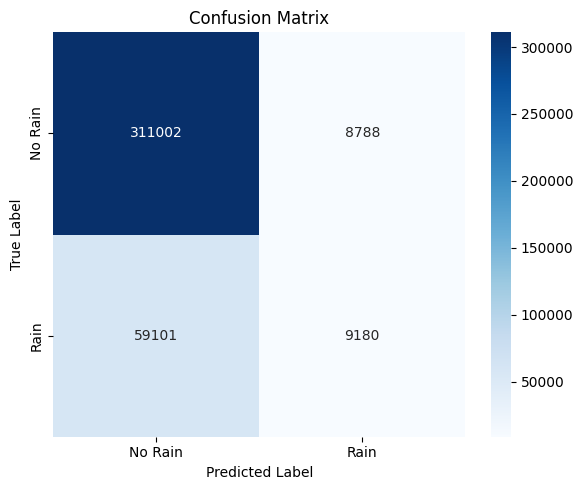

In [8]:
# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Rain', 'Rain'],
            yticklabels=['No Rain', 'Rain'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()

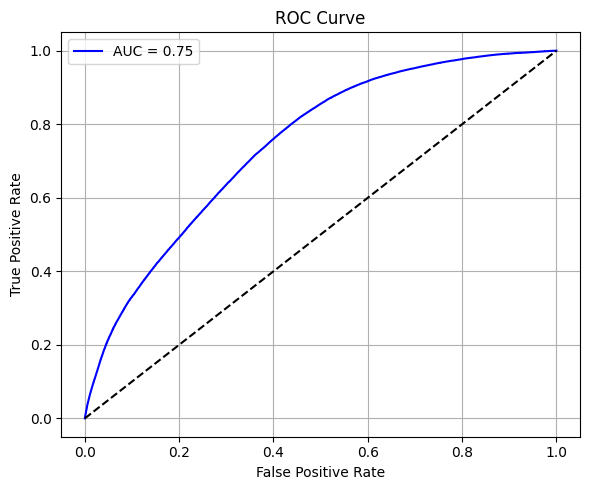

✅ Model outputs saved to 'model_predictions.csv'


In [ ]:

# ROC AUC and Curve
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='blue')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve.png")
plt.show()

# Save outputs for submission
pd.DataFrame({
    "TrueLabel": y_test,
    "PredictedProb": y_pred_prob,
    "PredictedLabel": y_pred
}).to_csv("model_predictions.csv", index=False)

print("✅ Model outputs saved to 'model_predictions.csv'")